<a href="https://colab.research.google.com/github/marcinwolter/Higgs_Janka/blob/main/Higgs_Janka_6v_tested10%25_allmasspoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Higgs analysis of Janka

author: Marcin Wolter, February 2021

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from IPython.display import Image 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from tensorflow.keras.layers.experimental import preprocessing

Read the cvs input data from google disk and create DataFrame

IMPORTANT: from background only a part of events is read (we read an equal number of signal and background events)

In [2]:
# Read csv data

from google.colab import drive
drive.mount('/content/drive')

masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1200, 1500, 2000, 2500]
#masses = [200, 250, 300, 350, 400, 500, 600, 700, 2500]

bckg = []
sig = []
for i in range(len(masses)):
  bckg_str = '/content/drive/MyDrive/jkrzysiak/data/Ztautau_'+str(masses[i])+'GeV.csv'
  bckg.append(pd.read_csv(bckg_str) )
  sig_str = '/content/drive/MyDrive/jkrzysiak/data/signal_'+str(masses[i])+'GeV.csv'
  sig.append(pd.read_csv(sig_str) )


#print(bckg)

XX = []
YY = []
WEIGHT = []

for i in range(len(masses)):
  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m',  'tau_pt', 'signal_mass']]
###  xs = sig[i][['MTtot',  'signal_mass']]
  xsw= sig[i][['weight']]
  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m',  'tau_pt', 'signal_mass']] #.head(len(xs))
###  xb = bckg[i][['MTtot',  'signal_mass']] #.head(len(xs))
  xbw= bckg[i][['weight']] #.head(len(xs))
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["vClass"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["vClass"])

  sum_sw = xsw.sum()
  sum_bw = xbw.sum()
  xsw = xsw.mul(sum_bw/sum_sw)

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  print(x.shape, y.shape, w.shape)



Mounted at /content/drive
(1414396, 5) (1414396, 1) (1414396, 1)
(1425476, 5) (1425476, 1) (1425476, 1)
(1446300, 5) (1446300, 1) (1446300, 1)
(1461095, 5) (1461095, 1) (1461095, 1)
(1471361, 5) (1471361, 1) (1471361, 1)
(1483219, 5) (1483219, 1) (1483219, 1)
(1448090, 5) (1448090, 1) (1448090, 1)
(1447411, 5) (1447411, 1) (1447411, 1)
(1445797, 5) (1445797, 1) (1445797, 1)
(1414950, 5) (1414950, 1) (1414950, 1)
(1395065, 5) (1395065, 1) (1395065, 1)
(1384146, 5) (1384146, 1) (1384146, 1)
(1375814, 5) (1375814, 1) (1375814, 1)


Prepare the global training dataset: 

1.   XX_all - input data
2.   YY_all - true labels
3.   WW_all - event weights

Than split the data between training and test datasets. 




In [3]:
# make overall training and validation set

XX_all = pd.concat(XX)
YY_all = pd.concat(YY)
WW_all = pd.concat(WEIGHT)

print(XX_all.shape, YY_all.shape, WW_all.shape)

x_train_all, x_test_all, y_train_all, y_test_all, sw_train_all, sw_test_all = train_test_split(XX_all, YY_all, WW_all, train_size=0.90, shuffle=True, random_state=42)



(18613120, 5) (18613120, 1) (18613120, 1)


In [4]:
# Define normalization of input data
layer = preprocessing.Normalization()
layer.adapt(x_train_all.to_numpy())

Prepare a small fully connected network

In [5]:
# prepare keras model

def define_model():
  n_nodes = 256 #16 #128
  dropout = 0.01
  # fully connected (dense) network
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_shape=(5,)))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  return model

Train the network

In [6]:
def fit_model(model, x_train, y_train, sw_train, x_val, y_val, sw_val):

  print("compiling")

  '''
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=False)
  '''  
  def lr_schedule(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        #return lr * pow(decay_rate, np.floor(epoch / decay_step))
        return lr * decay_rate
    return lr
  
  optimizer = tf.keras.optimizers.Adam() #learning_rate=lr_schedule)

  def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
  lr_metric = get_lr_metric(optimizer) 

  #metrics=[tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', # 'mse'  'binary_crossentropy'
              optimizer=optimizer, #"sgd",
              metrics=[tf.keras.metrics.AUC(name='auc'),lr_metric])
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=16,
    verbose=1,
    restore_best_weights=True
  )


  callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

  epochs = 100
  batch_size=128
  print("fitting")
  history = model.fit(x_train, y_train, 
                    sample_weight=sw_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val, sw_val),
                    callbacks=[es,callback])




  return history, model
#sample_weight = sw_train,

K-folding

In [7]:
# k-folding
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, sw, n_folds=5):

  scores, histories, models = list(), list(), list()
  
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, trainSW, testX, testY, testSW = dataX[train_ix], dataY[train_ix], sw[train_ix], dataX[test_ix], dataY[test_ix], sw[test_ix]
    # fit model
    print("fit_model")
    history, model = fit_model(model, trainX, trainY, trainSW, testX, testY, testSW)
    # evaluate model
    loss, auc, _  = model.evaluate(testX, testY, verbose=0)
    print(loss, auc)
		# stores scores
    scores.append(loss)
    histories.append(history)
    models.append(model)

    #save model
    aux = '/content/drive/MyDrive/jkrzysiak/model'+str(len(models)-1)+'.h5'
    model.save(aux)

    # break the loop to avoid k-folding
    break

  return scores, histories, models

Plot learning curves and summary of training

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification AUC')
    plt.plot(histories[i].history['auc'], color='blue', label='train')
    plt.plot(histories[i].history['val_auc'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['auc','val_auc'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()


Actual training. The input DataFrame is converted into numpy arrays

In [9]:
def network_fit(x_train_all, y_train_all, sw_train_all):


  #convert to numpy

  np_x_train_all = x_train_all.to_numpy()
  np_y_train_all = y_train_all.to_numpy()
  np_sw_train_all = sw_train_all.to_numpy()


  # convert class vectors to binary class matrices
  #np_y_train_all = to_categorical(np_y_train_all, num_classes=2)

  # normalize input data
  np_x_train_all = np.array(layer(np_x_train_all))

  # Train the network. 
  n_folds = 100  # number of folds
  scores, histories, models = evaluate_model(np_x_train_all, np_y_train_all, np_sw_train_all, n_folds=n_folds)

  return scores, histories, models

In [10]:
# train the network
scores, histories, models = network_fit(x_train_all, y_train_all, sw_train_all)

fit_model
compiling
fitting
Epoch 1/100
129565/129565 [==============================] - 457s 3ms/step - loss: 0.0590 - auc: 0.7415 - lr: 9.9971e-04 - val_loss: 0.0765 - val_auc: 0.7282 - val_lr: 0.0010
Epoch 2/100
129565/129565 [==============================] - 441s 3ms/step - loss: 0.3258 - auc: 0.7473 - lr: 8.4997e-04 - val_loss: -0.0383 - val_auc: 0.7023 - val_lr: 8.5000e-04
Epoch 3/100
129565/129565 [==============================] - 447s 3ms/step - loss: 0.2659 - auc: 0.6983 - lr: 7.2241e-04 - val_loss: 0.0907 - val_auc: 0.6491 - val_lr: 7.2251e-04
Epoch 4/100
129565/129565 [==============================] - 449s 3ms/step - loss: 0.2485 - auc: 0.7229 - lr: 6.1408e-04 - val_loss: 0.0970 - val_auc: 0.7712 - val_lr: 6.1412e-04
Epoch 5/100
129565/129565 [==============================] - 452s 3ms/step - loss: 0.2850 - auc: 0.7385 - lr: 5.2220e-04 - val_loss: 0.0772 - val_auc: 0.6772 - val_lr: 5.2201e-04
Epoch 6/100
129565/129565 [==============================] - 456s 4ms/step - los

Make plots

dict_keys(['loss', 'auc', 'lr', 'val_loss', 'val_auc', 'val_lr'])


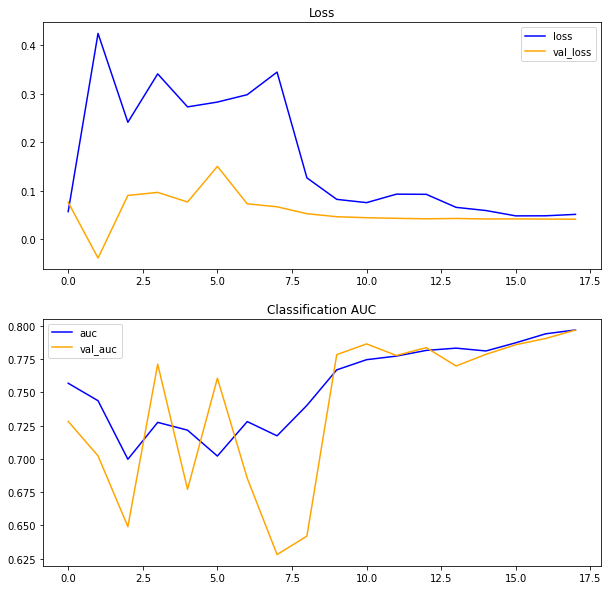

Accuracy: mean=224591.016 std=0.000, n=1


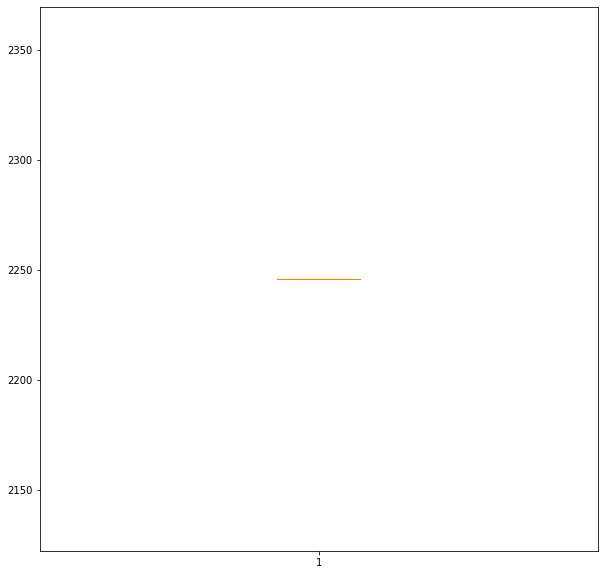

Scores:  [2245.91015625]


In [11]:
# learning curves
print(histories[0].history.keys() )
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)


Calculate AUC

In [12]:
def getAuc(x, y):
    """Compute Area Under the Curve (AUC) using the trapezoidal rule.
    This is a general function, given points on a curve.  For computing the
    area under the ROC-curve, see :func:`roc_auc_score`.  For an alternative
    way to summarize a precision-recall curve, see
    :func:`average_precision_score`.
    Parameters
    ----------
    x : ndarray of shape (n,)
        x coordinates. These must be either monotonic increasing or monotonic
        decreasing.
    y : ndarray of shape, (n,)
        y coordinates.
    Returns
    -------
    auc : float
    See Also
    --------
    roc_auc_score : Compute the area under the ROC curve.
    average_precision_score : Compute average precision from prediction scores.
    precision_recall_curve : Compute precision-recall pairs for different
        probability thresholds.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn import metrics
    >>> y = np.array([1, 1, 2, 2])
    >>> pred = np.array([0.1, 0.4, 0.35, 0.8])
    >>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    >>> metrics.auc(fpr, tpr)
    0.75
    """
    from sklearn.utils import check_consistent_length
    from sklearn.utils import column_or_1d, check_array


    check_consistent_length(x, y)
    x = column_or_1d(x)
    y = column_or_1d(y)

    if x.shape[0] < 2:
        raise ValueError('At least 2 points are needed to compute'
                         ' area under curve, but x.shape = %s' % x.shape)

    direction = 1
    dx = np.diff(x)

    if np.count_nonzero(dx>=0) < np.count_nonzero(dx<=0):
      direction = -1

    # remove elements with diff<=0 
    x=np.delete(x,np.nonzero(direction*dx <= 0))
    y=np.delete(y,np.nonzero(direction*dx <= 0))
    dx=np.delete(dx,np.nonzero(direction*dx <= 0))  
    #print("dx<0 indices are ", np.nonzero(dx <= 0),np.array((np.nonzero(dx <= 0))).shape,dx[dx<=0]) 

    area = direction * np.trapz(y, x)
    if isinstance(area, np.memmap):
        # Reductions such as .sum used internally in np.trapz do not return a
        # scalar by default for numpy.memmap instances contrary to
        # regular numpy.ndarray instances.
        area = area.dtype.type(area)
    return area

Build an ensamble of networks trained using k-folding and test it on test data

---



In [13]:
#ensamble of networks
def test_ensamble(x_test_all, y_test_all, sw_test_all):
  
  #Limit the number of events
  #n_events = 100000
  #x_test_all, y_test_all, sw_test_all = x_test_all[0:n_events], y_test_all[0:n_events], sw_test_all[0:n_events]


  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  np_y_test_all = y_test_all.to_numpy()
  np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()



  # normalize test data
  np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  # replace negative values by zero
  #summed[summed<0] = 0
  #summed_s[summed_s<0] = 0
  #summed_b[summed_b<0] = 0
  
  # func to calculate auc

  fpr, tpr, tresholds = roc_curve(np_y_test_all, summed, sample_weight=np_sw_test_all, drop_intermediate=False)
  print("Number of ROC thresholds: ", tresholds.shape)
  r_auc = getAuc(fpr,tpr)
  print('auc = ',r_auc)


  #m = tf.keras.metrics.AUC(num_thresholds=1000)
  #m.update_state(np_y_test_all, summed, sample_weight=np_sw_test_all)
  #r_auc = m.result().numpy()
  #print("r_auc (ensamble) == ",r_auc)

  aucs = []
  for i in range(len(models)):
    yyhats = models[i].predict(np_x_test_all)[:,0]
    #m.update_state(np_y_test_all, yyhats, sample_weight=np_sw_test_all)
    #aucs.append(m.result().numpy())
    fpr, tpr, tresholds = roc_curve(np_y_test_all, yyhats, sample_weight=np_sw_test_all, drop_intermediate=False)
    aucs.append(getAuc(fpr,tpr))


  av_auc = np.mean(aucs)

  

  #plot roc
  plt.figure(figsize=(6,4))
  plt.plot(1-fpr,tpr)
  plt.xlabel("Efficiency")
  plt.ylabel("Rejection")
  plt.title("ROC curve")
  plt.show()

  summed = summed.reshape((len(summed),1))
  summed_s = summed_s.reshape((len(summed_s),1))
  summed_b = summed_b.reshape((len(summed_b),1))

  
  plt.figure(figsize=(6,4))
  plt.hist(summed_s, weights=np_sw_test_all_s, bins=200, label="Signal",log=False, alpha=0.5, histtype='stepfilled')  
  plt.hist(summed_b, weights=np_sw_test_all_b, bins=200, label="Bckg.",log=False, alpha=0.5, histtype='stepfilled')
  plt.ylim(bottom=0)
  plt.xlabel("probability")
  plt.legend()
  plt.show()

  return r_auc, av_auc, aucs

Test accuracy

In [14]:
def accuracy_ensamble(x_test_all, y_test_all, sw_test_all):

  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  #np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  #np_y_test_all = y_test_all.to_numpy()
  #np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()

  np_sw_test_all_s = np_sw_test_all_s.reshape((len(np_sw_test_all_s)))
  np_sw_test_all_b = np_sw_test_all_b.reshape((len(np_sw_test_all_b)))

  # normalize test data
  #np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  #yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  #summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  cut=0.5
  summed_s[summed_s>cut] = 1
  summed_s[summed_s<cut] = 0
  summed_b[summed_b>cut] = 1
  summed_b[summed_b<cut] = 0

  isummed_s = summed_s.astype(np.int32)
  isummed_b = summed_b.astype(np.int32)


  false_neg, true_pos = np.bincount(isummed_s, weights=np_sw_test_all_s)
  #false_neg=np.bincount((1-isummed_s), weights=np_sw_test_all_s)
  true_neg, false_pos = np.bincount(isummed_b, weights=np_sw_test_all_b)
  #false_pos=np.bincount((1-isummed_b), weights=np_sw_test_all_b)

  #print("true_pos = ",true_pos)
  #print("false_neg = ",false_neg)
  #print("true_neg = ",true_neg)
  print("false_pos = ",false_pos)

  sensitivity = true_pos / (true_pos+false_neg)
  specificity = true_neg / (true_neg+false_pos)
  accuracy    = (true_pos + true_neg)/(true_pos + true_neg + false_neg + false_pos)

  print("accuracy = ",accuracy,", specificity = ", specificity,", sensitivity = ", sensitivity)

  return accuracy, specificity, sensitivity

Split test data according to signal_mass and test the classifier performance separately on each subsample

signal_mass =  200
Number of ROC thresholds:  (58091,)
auc =  0.9502768604858202


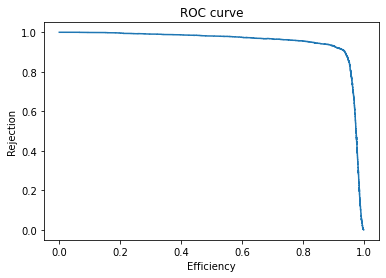

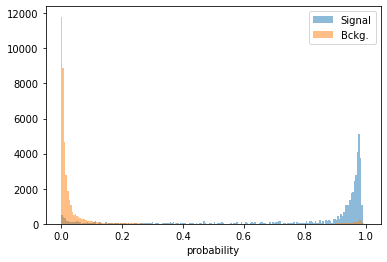

false_pos =  2082.8008056524604
accuracy =  0.9065025410617071 , specificity =  0.9490972440565721 , sensitivity =  0.8640882577965268
-------------------------------------------
signal_mass =  250
Number of ROC thresholds:  (61405,)
auc =  0.973161582210776


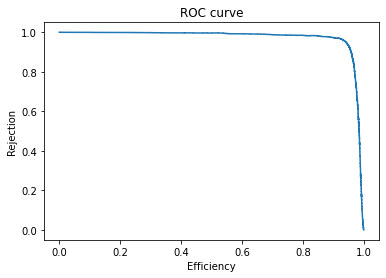

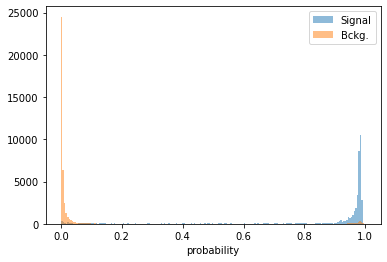

false_pos =  1767.0828084374116
accuracy =  0.9320879211450467 , specificity =  0.9566697207396353 , sensitivity =  0.9077048493510955
-------------------------------------------
signal_mass =  300
Number of ROC thresholds:  (66198,)
auc =  0.9851287933339374


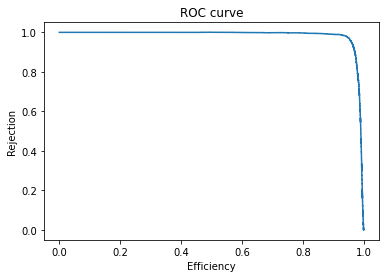

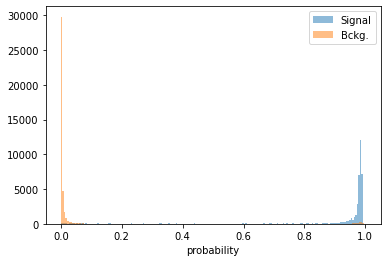

false_pos =  1435.2945575637677
accuracy =  0.9487530051834453 , specificity =  0.9649217075319658 , sensitivity =  0.9323946363727932
-------------------------------------------
signal_mass =  350
Number of ROC thresholds:  (69977,)
auc =  0.9888017470932524


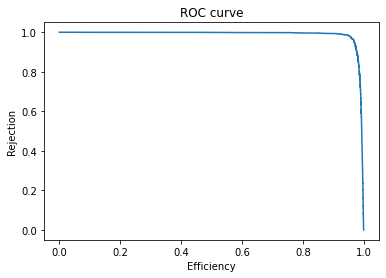

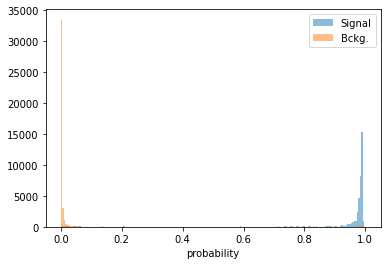

false_pos =  1296.0629020109825
accuracy =  0.9604708382334515 , specificity =  0.9685305982225614 , sensitivity =  0.9523426794603359
-------------------------------------------
signal_mass =  400
Number of ROC thresholds:  (73147,)
auc =  0.9922026819336558


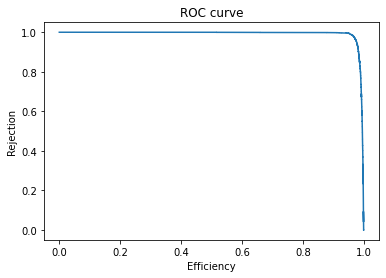

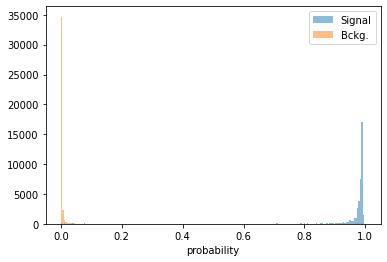

false_pos =  1152.8213776651826
accuracy =  0.9694003336363581 , specificity =  0.9714989435950616 , sensitivity =  0.9673143356615892
-------------------------------------------
signal_mass =  500
Number of ROC thresholds:  (80305,)
auc =  0.994856350121945


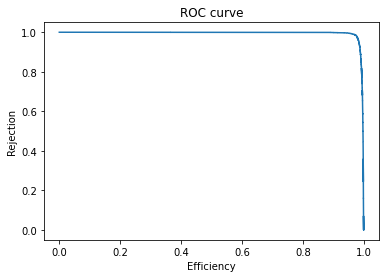

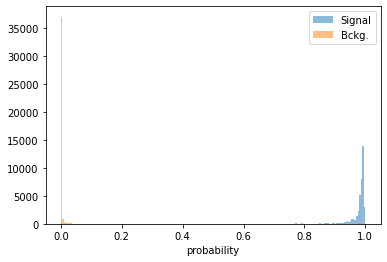

false_pos =  1012.1185117909179
accuracy =  0.9798074128895891 , specificity =  0.9750440386123618 , sensitivity =  0.9845247875267406
-------------------------------------------
signal_mass =  600
Number of ROC thresholds:  (76332,)
auc =  0.9964327522934391


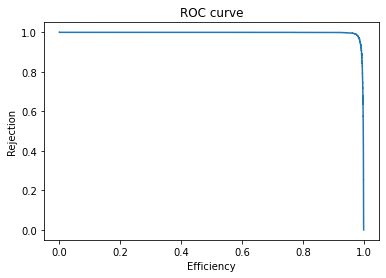

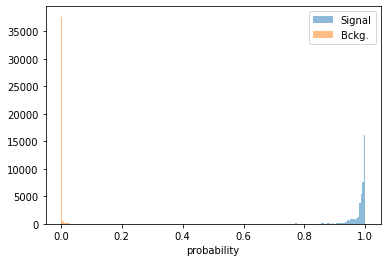

false_pos =  866.6836339804169
accuracy =  0.9818751144844126 , specificity =  0.9785035128865378 , sensitivity =  0.9850597401466975
-------------------------------------------
signal_mass =  700
Number of ROC thresholds:  (67368,)
auc =  0.9974704953263069


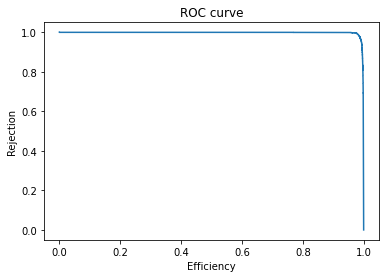

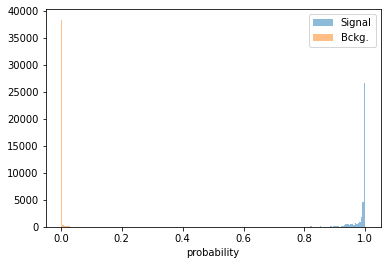

false_pos =  763.3922910175105
accuracy =  0.985138452287752 , specificity =  0.9812688716703929 , sensitivity =  0.9889279836888285
-------------------------------------------
signal_mass =  800
Number of ROC thresholds:  (61069,)
auc =  0.9974526914752841


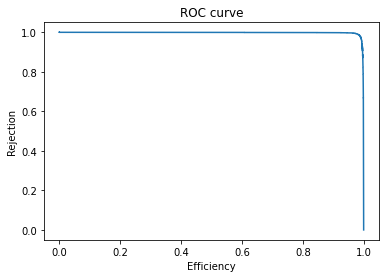

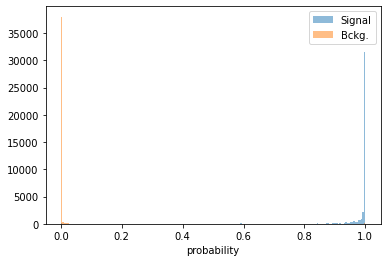

false_pos =  622.487742645596
accuracy =  0.9849324464523546 , specificity =  0.9844668650424913 , sensitivity =  0.9853872096941364
-------------------------------------------
signal_mass =  1200
Number of ROC thresholds:  (51563,)
auc =  0.9985630061830574


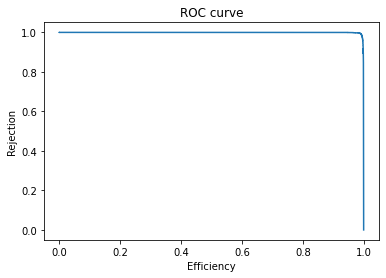

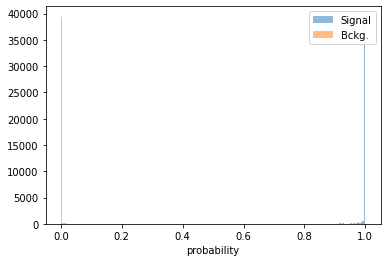

false_pos =  551.271790924475
accuracy =  0.9911913438927851 , specificity =  0.9865523499645411 , sensitivity =  0.9959406504086458
-------------------------------------------
signal_mass =  1500
Number of ROC thresholds:  (49575,)
auc =  0.997934094566594


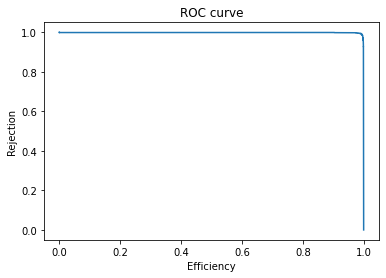

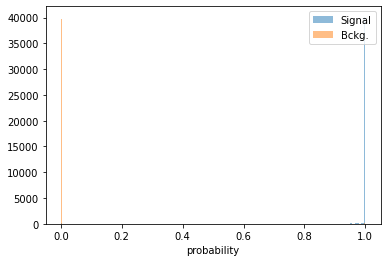

false_pos =  413.09127046665645
accuracy =  0.9920256089019963 , specificity =  0.9898244111702306 , sensitivity =  0.994181314169396
-------------------------------------------
signal_mass =  2000
Number of ROC thresholds:  (49103,)
auc =  0.9990964513411184


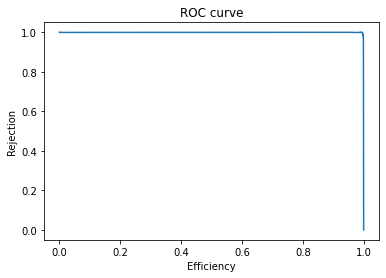

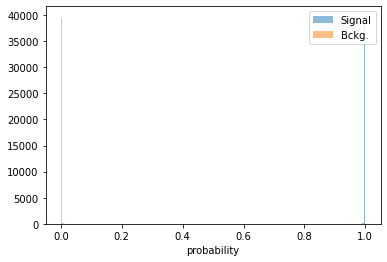

false_pos =  202.00730628358002
accuracy =  0.9970598312798665 , specificity =  0.994950458212028 , sensitivity =  0.9991495677282614
-------------------------------------------
signal_mass =  2500
Number of ROC thresholds:  (55220,)
auc =  0.9971524570877186


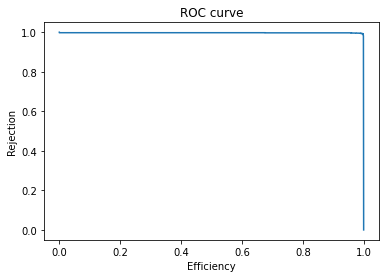

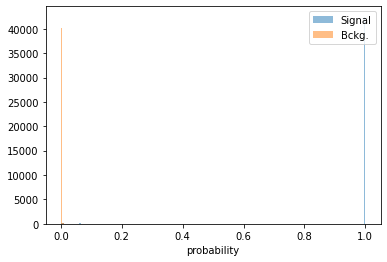

false_pos =  107.50779508847592
accuracy =  0.9941127066102714 , specificity =  0.9973541498518398 , sensitivity =  0.991042533716205
-------------------------------------------


In [15]:
auc_list = []
av_auc_list = []
aucs_list = []

acc_list = []
spec_list = []
sens_list = []

for m in masses:
  print("signal_mass = ",m)
  mask = np.in1d(x_test_all.signal_mass, m)
  #mask = np.in1d(x_train_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  #x_test_m = x_train_all[mask]
  #y_test_m = y_train_all[mask]
  #sw_test_m = sw_train_all[mask]

  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list.append(auc)
  av_auc_list.append(av_auc)
  aucs_list.append(aucs)

  accuracy, specificity, sensitivity = accuracy_ensamble(x_test_m, y_test_m, sw_test_m)
  acc_list.append(accuracy)
  spec_list.append(specificity)
  sens_list.append(sensitivity)
  
  print("-------------------------------------------")


Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

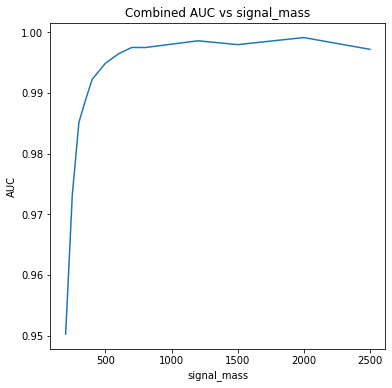

[0.9502768604858202]


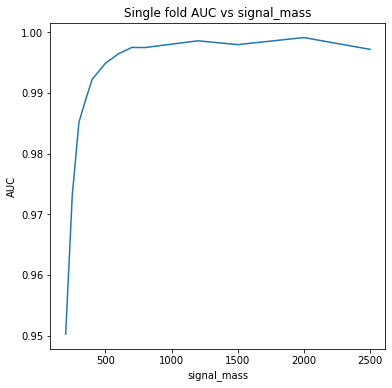

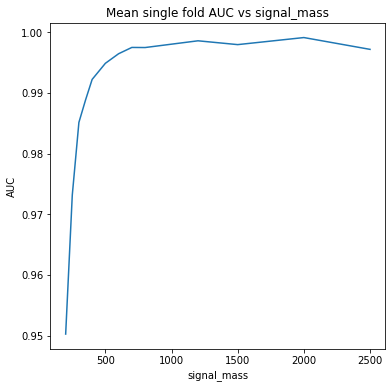

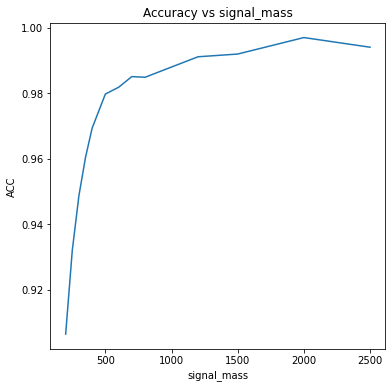

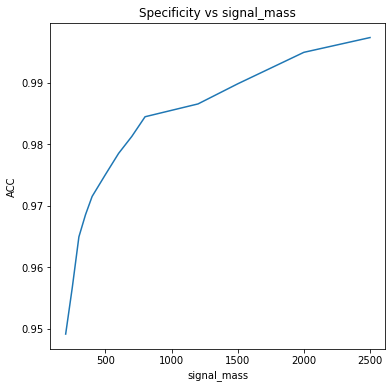

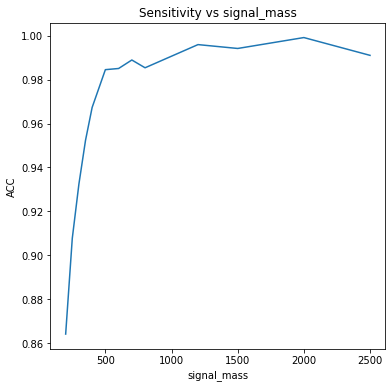

,signal_mass,comb. auc,mean auc,acc,specificity,sensitivity
0,200,0.950277,0.950277,0.906503,0.949097,0.864088
1,250,0.973162,0.973162,0.932088,0.956670,0.907705
2,300,0.985129,0.985129,0.948753,0.964922,0.932395
3,350,0.988802,0.988802,0.960471,0.968531,0.952343
4,400,0.992203,0.992203,0.969400,0.971499,0.967314
5,500,0.994856,0.994856,0.979807,0.975044,0.984525
6,600,0.996433,0.996433,0.981875,0.978504,0.985060
7,700,0.997470,0.997470,0.985138,0.981269,0.988928
8,800,0.997453,0.997453,0.984932,0.984467,0.985387
9,1200,0.998563,0.998563,0.991191,0.986552,0.995941


In [16]:

plt.figure(figsize=(6,6))
plt.plot(masses, np.array(auc_list))
plt.title('Combined AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()

print(aucs_list[0])

plt.figure(figsize=(6,6))
for i in range(len(aucs_list[0])):
  aux=[]
  for k in range(len(aucs_list)):
    aux.append(aucs_list[k][i])
  plt.plot(masses, np.array(aux))
plt.title('Single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(av_auc_list))
plt.title('Mean single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(acc_list))
plt.title('Accuracy vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(spec_list))
plt.title('Specificity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(sens_list))
plt.title('Sensitivity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list, av_auc_list, acc_list, spec_list, sens_list)), 
               columns =['signal_mass', 'comb. auc', 'mean auc', 'acc', 'specificity', 'sensitivity']) 
aucf

Stop program execution

In [17]:
import sys
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Split test data according to signal_mass, than train and test a network separately for each subsample. 

In [ ]:
auc_list_sep = []

for m in masses:
  print("signal_mass = ",m)

  #select events with a given signal_mass from the training dataset...
  mask = np.in1d(x_train_all.signal_mass, m)

  x_train_m = x_train_all[mask]
  y_train_m = y_train_all[mask]
  sw_train_m = sw_train_all[mask]

  # ...and from the test dataset
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  # train the network
  scores, histories, models = network_fit(x_train_m, y_train_m, sw_train_m)

  # learning curves
  print(histories[1].history.keys() )
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
  
  print("Scores: ",scores)

  # and now test the model
  auc_list_sep.append(test_ensamble(x_test_m, y_test_m, sw_test_m))

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

In [ ]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list_sep)
plt.title('AUC vs signal_mass (separate nets)')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list_sep)), 
               columns =['signal_mass', 'auc']) 
aucf